# # Import Dependencies

In [1]:
import numpy as np
import pandas as pd

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

from pprint import pprint
import scipy.sparse as ss
import matplotlib.pyplot as plt
import tkinter

import matplotlib
matplotlib.use('TkAgg')
import yellowbrick

from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


D:\Anaconda\envs\python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup NLP Pipeline and Data Cleaning 

In [3]:
##define nlp and start cleaning data
nlp= en_core_web_sm.load()

# List of stop words to equalize data
stop_list = ["Depression","depression"]

# Updates spaCy's default stop words list with my additional words. 
nlp.Defaults.stop_words.update(stop_list)

# Iterates over the words in the stop words list and resets the "is_stop" flag.
for word in STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True


In [4]:
#clean data

def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# The add_pipe function appends our functions to the default pipeline.
nlp.add_pipe(lemmatizer,name='lemmatizer',after='ner')
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)

## Import data, create a list of lists and push through NLP pipeline

In [5]:
doc_dep = pd.read_csv(r'Datasets/2020_March_r_Depression.csv')
doc_dep = doc_dep[doc_dep.Body != '[removed]']


In [6]:
#create a list of documents (list of lists) 
text_doc = doc_dep['Body'].tolist()

In [7]:
doc_list = []
# Iterates through each article in the corpus.
for doc in text_doc:
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(str(doc))
    doc_list.append(pr)

In [8]:
#However doc_list gives us each post as a list, with individual words being elements 
from nltk.tokenize.treebank import TreebankWordDetokenizer
empt = [];
for doc in doc_list:
    a1 = TreebankWordDetokenizer().detokenize(doc)
    empt.append(a1)
    
df_doc_dep = pd.DataFrame(empt,columns = ['Body'])
#df_doc_dep is a dataframe that has cleaned posts from Depression subreddit.
#all the 'removed' posts are gone and all the stopwords in the individual posts are gone! 

#both doc_list and df_doc are important (at least I think so :D)


df_doc_dep['label'] = 0

In [9]:
df_doc_dep

,Body,label
0,Uk cahms service shit sure schizophrenia fucki...,0
1,anybody luck holistic treatment gut health met...,0
2,leave bed 4:20pm work 5:00pm feel like walk dr...,0
3,want help people care feel right like wrong bo...,0
4,obviously want unhappy want depressed miserabl...,0
...,...,...
17546,finally open therapist feel happen pandemic st...,0
17547,need work day hate work hate wake early hate c...,0
17548,THEORY MASKS \n\n think visualize mask Mask p...,0
17549,lose pretty cry sorry mom dad longer second pa...,0


## Vectorize words with TFIDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    max_df=.2,
    min_df=8,
    max_features=None,
    ngram_range=(1, 1),
    norm=None,
    binary=True,
    use_idf=True,
    sublinear_tf=False
)

vectorizer = vectorizer.fit(df_doc_dep.Body)
tfidf = vectorizer.transform(df_doc_dep.Body)
vocab = vectorizer.get_feature_names()
print(len(vocab))

5580


## Get top 50 tokens 

In [11]:
fig, ax = plt.subplots(figsize=(10,9))
docs = vectorizer.fit_transform(df_doc_dep.Body)
features = vectorizer.get_feature_names()
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof()

## LDA Topic Modeling Semi-Supervised w/CorexTopic

In [12]:
#import corextopic

from corextopic import corextopic as ct
anchors = []
model = ct.Corex(n_hidden=6, seed=41)
model = model.fit(
    tfidf,
    words=vocab
)

D:\Anaconda\envs\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [14]:
alist=[]
for i, topic_ngrams in enumerate(model.get_topics(n_words=15)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    alist.append([" ".join(topic_ngrams)])
    print("Topic #{}: {}".format(i+1, " ,".join(topic_ngrams)))

Topic #1: way ,love ,person ,feeling ,care ,use ,point ,happy ,mind ,maybe ,understand ,world ,self ,thought ,wrong
Topic #2: school ,find ,lot ,old ,look ,read ,relationship ,high ,problem ,social ,kind ,change ,thank ,great ,meet
Topic #3: leave ,parent ,family ,mom ,dad ,end ,away ,house ,let ,mother ,break ,money ,father ,right ,shit
Topic #4: mental ,come ,health ,college ,hard ,issue ,class ,new ,able ,struggle ,situation ,support ,stress ,state ,therapist
Topic #5: month ,week ,ago ,long ,need ,anxiety ,ask ,happen ,stop ,post ,hour ,past ,sleep ,reason ,sorry
Topic #6: job ,home ,live ,play ,game ,lose ,spend ,watch ,bed ,stay ,sit ,video ,fall ,enjoy ,close


In [15]:
# Anchors designed to nudge the model towards measuring specific genres
anchors = [
    ["self"],
    ["relationship"],
    ["family"],
    ["stress"],
    ["time"],
    ["bed"],

]
anchors = [
    [a for a in topic if a in vocab]
    for topic in anchors
]

model = ct.Corex(n_hidden=6, seed=42)
model = model.fit(
    tfidf,
    words=vocab,
    anchors=anchors, # Pass the anchors in here
    anchor_strength=1 # Tell the model how much it should rely on the anchors
)

In [16]:
for i, topic_ngrams in enumerate(model.get_topics(n_words=15)):
    topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
    alist.append([" ".join(topic_ngrams)])
    print("Topic #{}: {}".format(i+1, " ,".join(topic_ngrams)))

Topic #1: way ,need ,mental ,self ,read ,anxiety ,health ,issue ,hard ,kind ,change ,struggle ,thank ,experience ,sure
Topic #2: come ,find ,love ,relationship ,lot ,person ,long ,look ,point ,ask ,problem ,girl ,lose ,let ,little
Topic #3: job ,live ,family ,home ,parent ,old ,leave ,month ,mom ,money ,pay ,house ,dad ,mother ,father
Topic #4: school ,college ,high ,class ,grade ,new ,study ,student ,graduate ,social ,drop ,university ,online ,fail ,semester
Topic #5: week ,sleep ,bed ,hour ,play ,eat ,night ,room ,sit ,spend ,watch ,walk ,game ,wake ,fall
Topic #6: care ,end ,away ,happy ,use ,anymore ,shit ,feeling ,die ,happen ,stop ,right ,cry ,mind ,hate


In [17]:
topic_df = pd.DataFrame(model.transform(tfidf), columns=["topic_{}".format(i+1) for i in range(6)]).astype(float)
topic_df.iloc[0:10]

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0


## Topic distribution

In [18]:
plt.figure(figsize=(10,5))
plt.bar(range(model.tcs.shape[0]), model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [19]:
# Print a single topic from CorEx topic model
model.get_topics(topic=0, n_words=30)
model.get_topics(topic=1, n_words=30)
model.get_topics(topic=2, n_words=30)
model.get_topics(topic=3, n_words=30)
model.get_topics(topic=4, n_words=30)
model.get_topics(topic=5, n_words=30)


[('care', 0.05964842919054841),
 ('end', 0.056553258180755295),
 ('away', 0.05063936317927625),
 ('happy', 0.046657756669074624),
 ('use', 0.046391228290857345),
 ('anymore', 0.04456972668987963),
 ('shit', 0.04264769240363392),
 ('feeling', 0.042293990399205283),
 ('die', 0.042170923365070945),
 ('happen', 0.04044888824441262),
 ('stop', 0.040012524966050955),
 ('right', 0.03937012711245358),
 ('cry', 0.03873070506379056),
 ('mind', 0.03850119092116949),
 ('hate', 0.03792327788481653),
 ('world', 0.03743270539653973),
 ('pain', 0.03741348433980651),
 ('head', 0.03634339320982266),
 ('thought', 0.03381841401600222),
 ('fuck', 0.031019386517337818),
 ('probably', 0.02939257381619492),
 ('hope', 0.02932513701080874),
 ('bring', 0.029267174468757966),
 ('hurt', 0.028947415269652662),
 ('wish', 0.027146149290428575),
 ('remember', 0.02684188242206256),
 ('fucking', 0.02676067746880933),
 ('matter', 0.025625440450731864),
 ('real', 0.025416487475978463),
 ('moment', 0.023873676844616273)]

In [20]:
from corextopic import vis_topic as vt
file = vt.vis_rep(model, column_label=words, prefix='topic-model-example')


NameError: name 'words' is not defined

# # termite plot

In [21]:
#create dataframe for termite plot
#termite_df = pd.DataFrame(columns=['Word', 'Weight', 'Topic'])
topic_0 = model.get_topics(topic=0, n_words=60)
topic_1 = model.get_topics(topic=1, n_words=60)
topic_2 = model.get_topics(topic=2, n_words=60)
topic_3 = model.get_topics(topic=3, n_words=60)
topic_4 = model.get_topics(topic=4, n_words=60)
topic_5 = model.get_topics(topic=5, n_words=60)
dict_topic_0 = {k:v for k,v in topic_0}
dict_topic_1 = {k:v for k,v in topic_1}
dict_topic_2 = {k:v for k,v in topic_2}
dict_topic_3 = {k:v for k,v in topic_3}
dict_topic_4 = {k:v for k,v in topic_4}
dict_topic_5 = {k:v for k,v in topic_5}
dict_df_0 = pd.DataFrame([dict_topic_0])
dict_df_1 = pd.DataFrame([dict_topic_1])
dict_df_2 = pd.DataFrame([dict_topic_2])
dict_df_3 = pd.DataFrame([dict_topic_3])
dict_df_4 = pd.DataFrame([dict_topic_4])
dict_df_5 = pd.DataFrame([dict_topic_5])
transposed_df_0 = dict_df_0.transpose().reset_index()
transposed_df_1 = dict_df_1.transpose().reset_index()
transposed_df_2 = dict_df_2.transpose().reset_index()
transposed_df_3 = dict_df_3.transpose().reset_index()
transposed_df_4 = dict_df_4.transpose().reset_index()
transposed_df_5 = dict_df_5.transpose().reset_index()
transposed_df_0 = transposed_df_0.rename(columns={transposed_df_0.columns[0]:'words', transposed_df_0.columns[1]: "tfidf"})
transposed_df_1 = transposed_df_1.rename(columns={transposed_df_1.columns[0]:'words', transposed_df_1.columns[1]: "tfidf"})
transposed_df_2 = transposed_df_2.rename(columns={transposed_df_2.columns[0]:'words', transposed_df_2.columns[1]: "tfidf"})
transposed_df_3 = transposed_df_3.rename(columns={transposed_df_3.columns[0]:'words', transposed_df_3.columns[1]: "tfidf"})
transposed_df_4 = transposed_df_4.rename(columns={transposed_df_4.columns[0]:'words', transposed_df_4.columns[1]: "tfidf"})
transposed_df_5 = transposed_df_5.rename(columns={transposed_df_5.columns[0]:'words', transposed_df_5.columns[1]: "tfidf"})
transposed_df_0['topic'] = 0
transposed_df_1['topic'] = 1
transposed_df_2['topic'] = 2
transposed_df_3['topic'] = 3
transposed_df_4['topic'] = 4
transposed_df_5['topic'] = 5

In [22]:
concat_1 = pd.concat([transposed_df_0, transposed_df_1])
concat_2 = pd.concat([transposed_df_2, transposed_df_3])
concat_3 = pd.concat([transposed_df_4, transposed_df_5])
concat_pre_final_1 = pd.concat([concat_1, concat_2])
termite_df = pd.concat([concat_pre_final_1, concat_3])

In [23]:
termite_df.to_csv(r'word_topic_data.csv')
len(termite_df)

360

In [24]:
termite_df

,words,tfidf,topic
0,way,0.064833,0
1,need,0.057376,0
2,mental,0.054829,0
3,self,0.048971,0
4,read,0.047927,0
...,...,...,...
55,push,0.017635,5
56,deal,0.017038,5
57,human,0.016219,5
58,type,0.016142,5


In [25]:
termite_df_new = termite_df['words']


In [26]:
termite_df = pd.read_csv(r'word_topic_data_termite.csv')
termite_df.index = termite_df.words
termite_df = termite_df.drop(columns = 'words')
termite_df = termite_df.fillna(0)

In [32]:
termite_df

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5
words,,,,,,
able,0.000000,0.000000,0.030841,0.0,0.000000,0.000000
actually,0.028633,0.000000,0.000000,0.0,0.000000,0.000000
age,0.000000,0.000000,0.026422,0.0,0.000000,0.000000
ago,0.000000,0.038652,0.000000,0.0,0.000000,0.000000
anxiety,0.047012,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...
watch,0.000000,0.000000,0.000000,0.0,0.036241,0.000000
weight,0.000000,0.000000,0.000000,0.0,0.022221,0.000000
wish,0.000000,0.000000,0.000000,0.0,0.000000,0.027146


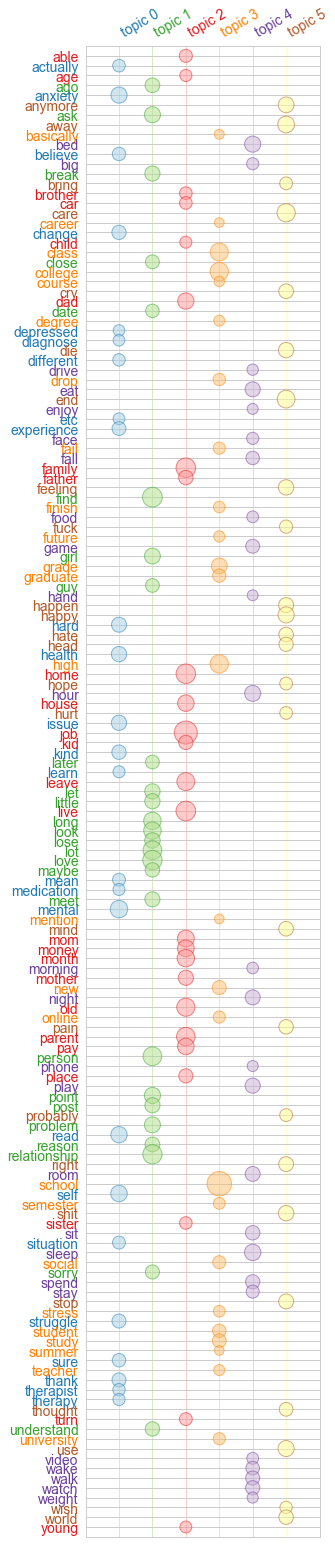

In [34]:
%matplotlib inline
from textacy.viz.termite import draw_termite_plot

draw_termite_plot(np.array(termite_df.values),
                  termite_df.columns,
                  termite_df.index, 
                  highlight_cols=[0,1, 2, 3, 4, 5])

## TSNE Visualization 

In [35]:
import random
topic_df = pd.DataFrame(
    model.transform(tfidf), 
    columns=["t{}".format(i+1) for i in range(6)]
).astype(float)
topic_df.astype(int)
a1=[];
for i in range(topic_df.shape[0]):
    a2 = list(topic_df.iloc[i][topic_df.iloc[i]==1].index)
    random.shuffle(a2)
    a1.append(a2)
    
topic_df['label'] = a1


In [36]:
a2 = [topic_df.label[i] != [] for i in range(topic_df.shape[0])]
topic_df = topic_df[a2]

In [37]:
topic_df['new_label'] = [topic_df['label'].iloc[i][0] for i in range(topic_df.shape[0])]

In [38]:
new_corpus = df_doc_dep.iloc[topic_df.index]
new_corpus.label =  topic_df['new_label']

D:\Anaconda\envs\python37\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [39]:
new_corpus1 = new_corpus.sample(n=1000)
new_corpus1

,Body,label
4052,everyday work idea struggle force bubbly happy...,t5
2557,tired outside anymore vibration low parent anx...,t3
2497,happen huge family rift leave completely isola...,t1
11465,depressed ass brush hair month today finally b...,t5
10461,17 turn 18 young know mean longer lose single ...,t6
...,...,...
10350,grow extremely poor bad neighborhood mother si...,t2
859,stop stick past anxious future fully present f...,t6
11264,guess course dream reckless thing feel alive f...,t6
12359,past couple year suffer point attempt commit s...,t2


In [129]:
# from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer


# Load the data and create document vectors
corpus = new_corpus1.Body

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus)
y = new_corpus1.label

# Create the visualizer and draw the vectors
fig, ax = plt.subplots(figsize=(20,10))
tsne = TSNEVisualizer()
tsne_coords = tsne.fit(X, y)
tsne_coords.show()


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [146]:
from sklearn.manifold import TSNE
tsne_sec = TSNE(n_components=3,random_state=0, perplexity= 30, n_iter=5000)
fit_transform = tsne_sec.fit_transform(X)

In [157]:
mid = int(len(fit_transform)/2)

In [169]:
from matplotlib import interactive
interactive(True)
from IPython import get_ipython
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(111, projection='3d')
# mid = int(len(tsne[0,:])/2)
ax.scatter(fit_transform[:,0][0:mid], fit_transform[:,0][0:mid], fit_transform[:,0][0:mid], c= 'r', s = 100, marker='.')
ax.scatter(fit_transform[:,1][0:mid], fit_transform[:,1][0:mid], fit_transform[:,1][0:mid], c= 'b', s = 100, marker='.')
ax.scatter(fit_transform[:,2][0:mid], fit_transform[:,2][0:mid], fit_transform[:,2][0:mid], c= 'g', s = 100, marker='.')
# ax.scatter(tsne_sec[:,2], c= 'g', s = 100, marker='.')

# ax.scatter(np.array(termite_df.values)[:,0], np.random.rand(0,1), c="r", marker="o")
# ax.scatter(np.array(termite_df.values)[:,1], np.random.rand(1,2), c="b", marker="o")
# ax.scatter(np.array(termite_df.values)[:,2], np.random.rand(2,3), c="g", marker="o")
# ax.scatter(np.array(termite_df.values)[:,3], np.random.rand(3,4), c="r", marker="o")
# ax.scatter(np.array(termite_df.values)[:,4], np.random.rand(4,5), c="r", marker="o")
# ax.scatter(np.array(termite_df.values)[:,5], np.random.rand(5,6), c="r", marker="o")

# ax.scatter(*zip(*tsne), c="r", marker="o")

# get_ipython().run_line_magic('matplotlib', 'qt')
plt.show()

In [163]:
fit_transform[:,0][mid:]

array([ 205.61093  ,  304.2114   , -195.56833  ,  -77.864746 ,
       -221.14778  ,  263.8035   ,  250.13307  , -354.38455  ,
         -3.4326086, -199.2473   ,  197.79573  , -110.21034  ,
         83.8624   , -363.02145  ,   71.39377  ,  124.632835 ,
        -66.05016  ,  274.71063  , -269.0007   ,  -85.200226 ,
       -267.1175   ,  119.73064  ,  -11.801244 , -201.68127  ,
         76.47049  ,    7.1405153, -112.080284 ,  221.56665  ,
        176.63237  , -335.9951   ,   46.008724 ,  174.75685  ,
       -394.15396  ,  114.72022  ,  -56.643867 ,  247.78453  ,
        121.36463  ,   42.963673 ,   59.90728  ,  199.31694  ,
        128.37845  ,  136.77068  , -118.18826  ,  274.84973  ,
       -298.04984  , -104.64805  , -190.3136   , -300.94766  ,
       -215.03905  , -159.19821  ,   -9.48363  , -228.65045  ,
        -55.08058  ,  173.46246  ,   41.627804 ,  -26.502722 ,
        238.19942  , -231.54663  , -106.22917  ,  417.84125  ,
         59.01406  , -101.17987  ,  265.0929   ,  -84.0

In [91]:
np.array(termite_df.values)[:, 5]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04456973, 0.        , 0.05063936, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.02926717, 0.        ,
       0.        , 0.05964843, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0387307 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04217092, 0.        , 0.        , 0.        , 0.        ,
       0.05655326, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.04229399,
       0.        , 0.        , 0.        , 0.03101939, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.04044889, 0.04665776, 0.        , 0.03792328,
       0.03634339, 0.        , 0.        , 0.        , 0.02932514,
       0.        , 0.        , 0.02894742, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
#from corextopic import vis_topic as vt
#vt.vis_rep(model, column_label=words, prefix='topic-model-example')

CorEx is a discriminative model, whereas LDA is a generative model. This means that while LDA outputs a probability distribution over each document, CorEx instead estimates the probability a document belongs to a topic given that document's words. As a result, the probabilities across topics for a given document do not have to add up to 1. The estimated probabilities of topics for each document can be accessed through log_p_y_given_x or p_y_given_x.

## LDA Unsupervised

In [172]:
# Creates, which is a mapping of word IDs to words.
words = corpora.Dictionary(doc_list)

# Turns each document into a bag of words.
corpus = [words.doc2bow(doc) for doc in doc_list]

In [173]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=words,
                                           num_topics=6, 
                                           random_state=2,
                                           update_every=1,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [174]:
#print the keyword in the 6 topics
pprint(lda_model.print_topics(num_words=100))

[(0,
  '0.042*"feel" + 0.034*"like" + 0.028*"\n'
  '\n'
  ' " + 0.024*"want" + 0.020*"know" + 0.020*"life" + 0.015*"think" + '
  '0.014*"thing" + 0.014*"time" + 0.012*"people" + 0.011*"try" + 0.009*"bad" + '
  '0.009*"good" + 0.009*"day" + 0.008*"love" + 0.007*"way" + 0.007*"anymore" + '
  '0.007*"year" + 0.007*"live" + 0.007*"hate" + 0.006*"friend" + 0.006*"happy" '
  '+ 0.006*"end" + 0.006*"care" + 0.006*"die" + 0.005*"shit" + 0.005*"  " + '
  '0.005*"fuck" + 0.005*"find" + 0.005*"hard" + 0.005*"fucking" + 0.005*"work" '
  '+ 0.005*"right" + 0.005*"family" + 0.004*"point" + 0.004*"person" + '
  '0.004*"look" + 0.004*"lose" + 0.004*"come" + 0.004*"thought" + 0.004*"wish" '
  '+ 0.004*"kill" + 0.004*"need" + 0.004*"feeling" + 0.004*"start" + '
  '0.004*"away" + 0.004*"stop" + 0.004*"leave" + 0.004*"long" + 0.004*"tired" '
  '+ 0.004*"happen" + 0.004*"maybe" + 0.004*"hope" + 0.004*"world" + '
  '0.003*"sad" + 0.003*"depressed" + 0.003*"use" + 0.003*"hurt" + 0.003*"self" '
  '+ 0.003*"ch

In [175]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=doc_list):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(100)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4398,"feel, like, \n\n , want, know, life, think, th...","[Uk, cahms, service, shit, sure, schizophrenia..."
1,1,0.0,0.3836,"feel, like, \n\n , want, know, life, think, th...","[anybody, luck, holistic, treatment, gut, heal..."
2,2,0.0,0.6597,"feel, like, \n\n , want, know, life, think, th...","[leave, bed, 4:20pm, work, 5:00pm, feel, like,..."
3,3,0.0,0.7233,"feel, like, \n\n , want, know, life, think, th...","[want, help, people, care, feel, right, like, ..."
4,4,0.0,0.8175,"feel, like, \n\n , want, know, life, think, th...","[obviously, want, unhappy, want, depressed, mi..."
...,...,...,...,...,...
95,95,0.0,0.6650,"feel, like, \n\n , want, know, life, think, th...","[wake, morning, like, greet, day, hell, look, ..."
96,96,3.0,0.3337,"\n\n , mental, health, medication, anxiety, he...","[hi, \n\n , extra, mile, frustrate, negatively..."
97,97,0.0,0.4210,"feel, like, \n\n , want, know, life, think, th...","[struggle, friend, single, friend, world, dog,..."
98,98,0.0,0.7368,"feel, like, \n\n , want, know, life, think, th...","[think, future, feel, like, weight, press, che..."


In [176]:
df_dominant_topic.head(25)
#df_dominant_topic.to_csv(r'depression_2020_datest.csv')

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.4398,"feel, like, \n\n , want, know, life, think, th...","[Uk, cahms, service, shit, sure, schizophrenia..."
1,1,0.0,0.3836,"feel, like, \n\n , want, know, life, think, th...","[anybody, luck, holistic, treatment, gut, heal..."
2,2,0.0,0.6597,"feel, like, \n\n , want, know, life, think, th...","[leave, bed, 4:20pm, work, 5:00pm, feel, like,..."
3,3,0.0,0.7233,"feel, like, \n\n , want, know, life, think, th...","[want, help, people, care, feel, right, like, ..."
4,4,0.0,0.8175,"feel, like, \n\n , want, know, life, think, th...","[obviously, want, unhappy, want, depressed, mi..."
5,5,0.0,0.5502,"feel, like, \n\n , want, know, life, think, th...","[watch, countless, reddit, video, topic, creat..."
6,6,0.0,0.5789,"feel, like, \n\n , want, know, life, think, th...","[know, write, feel, like, place, thing, moment..."
7,7,0.0,0.8582,"feel, like, \n\n , want, know, life, think, th...","[society, fucking, want, dead, wish, honestly,..."
8,8,0.0,0.4843,"feel, like, \n\n , want, know, life, think, th...","[\n , 26, yo, \n\n , ready, honestly, end, hel..."
9,9,0.0,0.8469,"feel, like, \n\n , want, know, life, think, th...","[Indica, edible, Wednesday, feel, amazing, usu..."


In [177]:
from collections import Counter
Counter(df_dominant_topic.Dominant_Topic)

Counter({0.0: 15896, 5.0: 285, 4.0: 193, 3.0: 375, 2.0: 317, 1.0: 485})

In [178]:
dictionary = words
corpus = corpus
lda = lda_model

In [180]:
!pip install pyLDAvis

  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97715 sha256=f815c866f3dfa796d74efbcf7a49d96df26632b41cef729f94f29798517c56dc
  Stored in directory: C:\Users\aydin\AppData\Local\pip\Cache\wheels\98\71\24\513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491063 sha256=30f477fa108e8713aa2462e1f98bd19c552079d708f8dbe44fdfffde9c5ba478
  Stored in directory: C:\Users\aydin\AppData\Local\pip\Cache\wheels\8b\99\a0\81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32045 sha256=d27547e321571159a5169906e2872c211ef62cdeffb9f621b9c854f3278e92ca
  Stored in directory: C:\Users\aydin\AppData\Local\pip\Cache\wheels\20\5a\d8\1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis future funcy


In [ ]:
import pyLDAvis.gensim

%timeit data = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.show(data)